In [ ]:
!pip install langchain-fireworks

In [1]:
import os
import sys
import logging
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from typing import List, Dict, Any

from dotenv import load_dotenv
from langchain_sambanova import ChatSambaStudio, ChatSambaNovaCloud
from langchain_fireworks import ChatFireworks 
from langchain_core.prompts import PromptTemplate

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, '..'))
repo_dir = os.path.abspath(os.path.join(kit_dir, '..'))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

load_dotenv(os.path.join(repo_dir, '.env'), override=True)

/Users/jorgep/Documents/ask_public_own/guardenv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in SambaStudioEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


True

# Set LLMs

In [2]:
# chat models to evaluate

llm_sambanova_cloud = ChatSambaNovaCloud(
    max_tokens=1024, 
    model='Meta-Llama-3.1-8B-Instruct',
    temperature=0.01
    )

llm_sambastudio = ChatSambaStudio(
    max_tokens=1024, 
    model='Meta-Llama-3.1-8B-Instruct',
    temperature=0.01
    )

llm_provider1 = ChatFireworks(
    max_tokens=1024, 
    model="accounts/fireworks/models/llama-v3p1-8b-instruct",
    temperature=0.01
)

# Set Guardrails models

In [3]:
# guardrail models to evaluate

guardrails_sambanova_cloud = ChatSambaNovaCloud(
    max_tokens=4096, 
    model='Meta-Llama-Guard-3-8B',
    temperature=0.01
    )

guardrails_sambastudio = ChatSambaStudio(
    max_tokens=4096, 
    model='Meta-Llama-Guard-3-8B',
    temperature=0.01,
    )

guardrails_provider1 = ChatFireworks(
    max_tokens=4096, 
    model='accounts/fireworks/models/llama-guard-3-8b',
    temperature=0.01
)

# Guardrails evaluation methods

In [4]:
unsafe_categories = """S1: Violent Crimes.
AI models should not create content that enables, encourages, or excuses the commission of violent crimes. Examples of violent crimes include, but are not limited to:
- Unlawful violence toward people (ex: terrorism, genocide, murder, hate crimes, child abuse, assault, battery, kidnapping)
- Unlawful violence toward animals (ex: animal abuse)
S2: Non-Violent Crimes.
AI models should not create content that enables, encourages, or excuses the commission of non-violent crimes. Examples of non-violent crimes include, but are not limited to:
- Financial crimes (ex: fraud, scams, money laundering)
- Property crimes (ex: burglary, robbery, arson, vandalism)
- Drug crimes (ex: creating or trafficking narcotics)
- Weapons crimes (ex: producing unlicensed firearms)
- Cyber crimes (ex: hacking, spyware, malware)
S3: Sex Crimes.
AI models should not create content that enables, encourages, or excuses the commission of sex crimes. Examples of sex crimes include, but are not limited to:
- Human trafficking
- Sexual assault (ex: rape)
- Sexual harassment (ex: groping)
- Lewd conduct
S4: Child Exploitation.
AI models should not create content that depicts child nudity or that enables, encourages, excuses, or depicts the sexual abuse of children.
S5: Specialized Advice.
AI models should not create content that contains specialized financial, medical, or legal advice.
S6: Privacy.
AI models should not create content that contains sensitive, personal information about private individuals.
S7: Intellectual Property.
AI models should not create content that violates the intellectual property rights of third parties.
S8: Indiscriminate Weapons.
AI models should not create content that enables the creation of weapons of mass destruction. Examples of such weapons include, but are not limited to:
- Chemical weapons (ex: nerve gas)
- Biological weapons (ex: anthrax)
- Radiological weapons (ex: salted bombs)
- Nuclear weapons (ex: atomic warheads)
- High-yield explosive weapons (ex: cluster munitions)
S9: Hate.
AI models should not create content that is hateful toward people on the basis of their protected characteristics (race, color, ethnicity, national origin, disability, religious affiliation, caste, sexual orientation, sex, gender identity and serious disease). AI models should not create content that perpetuates negative stereotypes.
S10: Self-Harm.
AI models should not create content that enables, encourages, or excuses acts of intentional self-harm. Examples of such actions include, but are not limited to:
- Suicide
- Self-injury (ex: cutting)
- Disordered eating
S11: Sexual Content.
AI models should not create depictions of nude adults or content that contains erotic descriptions or explicit depictions of sex acts.
<END UNSAFE CONTENT CATEGORIES>
)"""

def evaluate_guardrails(guardrails_model, input, role, unsafe_categories=unsafe_categories):
    guardrails_prompt_template = PromptTemplate.from_template(
        """<|begin_of_text|>[INST] Task: Check if there is unsafe content in '{role}' messages in conversations according our safety policy with the below categories.

        <BEGIN UNSAFE CONTENT CATEGORIES>
        {unsafe_categories}
        <END UNSAFE CONTENT CATEGORIES>

        <BEGIN CONVERSATION>

        {conversation}
        <END CONVERSATION>

        Provide your safety assessment for ONLY THE LAST {role} in the above conversation:
        - First line must read 'safe' or 'unsafe'.
        - If unsafe, a second line must include a comma-separated list of violated categories. [/INST]"""
    )
    if isinstance(input, str):
        conversation = f"{role.capitalize()}: {input}\n\n"
    elif isinstance(input, list):
        conversation = ""
        for turn in conversation:
            conversation += f"{turn['role'].capitalize()}: {turn['content']}\n\n"
        
    prompt = guardrails_prompt_template.format(
        unsafe_categories = unsafe_categories,
        conversation= conversation,
        role = role
    )
    
    return guardrails_model.invoke(prompt)

# Workflow with Guardrails methods

In [5]:
def invoke_with_guardrails_metrics(llm, guardrails_model, prompt):
    response = {}
    client_latencies={}
    client_latencies["start_time"] = time.time()
    guardrails_user_response = evaluate_guardrails(guardrails_model, prompt, role = "user")
    response["guardrails_user_response"]=guardrails_user_response
    client_latencies["user_guardrails_end_time"] = time.time()
    client_latencies["user_guardrails_time"] = client_latencies["user_guardrails_end_time"]-client_latencies["start_time"]
    if guardrails_user_response.content.strip().split("\n")[0] == "unsafe":
        logging.warning("User input {} has violated guardrails: {}".format(prompt, guardrails_user_response.content.replace('\n', ' ')))
        response["client_latencies"]=client_latencies
        return response
    llm_response = llm.invoke(prompt)
    response["llm_response"]=llm_response
    client_latencies["llm_generation_end_time"] = time.time()
    client_latencies["llm_generation_time"] = client_latencies["llm_generation_end_time"]-client_latencies["user_guardrails_end_time"]
    client_latencies["end_time_2_calls"] = client_latencies["llm_generation_end_time"]
    client_latencies["e2e_2_calls_time"] = client_latencies["end_time_2_calls"]-client_latencies["start_time"]
    guardrails_assistant_response = evaluate_guardrails(
        guardrails_model,
        [{
            "user": prompt, 
            "assistant": llm_response.content 
        }],
        role = "assistant"
        )
    response["guardrails_assistant_response"]=guardrails_assistant_response
    client_latencies["assistant_guardrails_end_time"] = time.time()
    client_latencies["assistant_guardrails_time"] = client_latencies["assistant_guardrails_end_time"]-client_latencies["llm_generation_end_time"]
    client_latencies["end_time_3_calls"] = client_latencies["assistant_guardrails_end_time"]
    client_latencies["e2e_3_calls_time"] = client_latencies["end_time_3_calls"]-client_latencies["start_time"]
    if guardrails_assistant_response.content.strip().split("\n")[0] == "unsafe":
        logging.warning("Model response {} has violated guardrails: {}".format(llm_response.content, guardrails_assistant_response.content.replace('\n', ' ')))
    response["client_latencies"]=client_latencies
    return response

# Benchmark methods

In [6]:
def call_providers_in_parallel(prompt):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_sambanovacloud = executor.submit(invoke_with_guardrails_metrics, llm_sambanova_cloud, guardrails_sambanova_cloud, prompt)
        future_sambastudio = executor.submit(invoke_with_guardrails_metrics, llm_sambastudio, guardrails_sambastudio, prompt) 
        future_provider1 = executor.submit(invoke_with_guardrails_metrics, llm_provider1, guardrails_provider1, prompt)

        sambanovacloud_workflow_response = future_sambanovacloud.result()
        sambastudio_workflow_response = future_sambastudio.result()
        provider1_workflow_response = future_provider1.result()
    return {
        "sambanovacloud": sambanovacloud_workflow_response,
        "sambastudio": sambastudio_workflow_response, 
        "provider1": provider1_workflow_response
        }


In [12]:
def run_benchmark(prompts, iterations):
    results = []
    for it in range(iterations):
        print(f"running iteration {it}")
        for id, prompt in enumerate(prompts): 
            print(f"\trunning prompt {id}")
            results.append(call_providers_in_parallel(prompt))
    return results

# Analyze and plot metrics methods

In [37]:
def get_metrics_as_table(runs: List[Dict[str,Any]]) -> pd.DataFrame:    
    # Extract data and organize into a DataFrame
    data = []
    for run_idx, run in enumerate(runs):
        for provider, metrics in run.items():
            latencies = metrics['client_latencies']
            latencies = {key:value for key,value in latencies.items() if key in ['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time', 'e2e_2_calls_time', 'e2e_3_calls_time']}
            data.append({"Run": run_idx + 1, "Provider": provider, **latencies})
    return pd.DataFrame(data)

def get_stats(df: pd.DataFrame) -> pd.DataFrame:
    stats = df.groupby("Provider")[['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time', 'e2e_2_calls_time', 'e2e_3_calls_time']].agg(['mean', 'std', 'min', 'max'])
    return stats

def plot_comparison_barcharts_2_calls(df: pd.DataFrame) -> None:
    # Plot bar charts comparing providers
    latency_columns = ['user_guardrails_time', 'llm_generation_time', 'e2e_2_calls_time']
    latency_columns_titles = {
        'user_guardrails_time': "Latency comparison: Guardrails on User's Prompt" , 
        'llm_generation_time': "Latency comparison: LLM generation" ,  
        'e2e_2_calls_time': 'E2E Latency comparison for 2 calls workflow'
    }
    _, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, col in enumerate(latency_columns):
        ax = axes[idx]
        sns.barplot(
            data=df, 
            x="Provider", 
            y=col, 
            hue="Provider",
            ax=ax, 
            legend=False,
            estimator='mean',
            errorbar=('pi', 50)
        )
        ax.set_title(latency_columns_titles[col])
        ax.set_ylabel("Time (s)")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show();
    
def newplot(df):
    stacked_data = df.melt(id_vars=["Provider", "Run"], 
                       value_vars=['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time'], 
                       var_name="Latency Type", 
                       value_name="Time (s)")

    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=stacked_data, 
        x="Provider", 
        y="Time (s)", 
        hue="Latency Type", 
        ci="sd", 
        palette="viridis"
    )
    plt.title("Stacked Latency Times per Provider")
    plt.ylabel("Time (s)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Latency Type")
    plt.tight_layout()
    plt.show()
    
def plot_comparison_barcharts(df: pd.DataFrame) -> None:
    # Plot bar charts comparing providers
    latency_columns = ['e2e_2_calls_time', 'e2e_3_calls_time']
    latency_columns_titles = {
        'e2e_2_calls_time': 'E2E Latency for 2 API Calls',
        'e2e_3_calls_time': 'E2E Latency for 3 API Calls'
    }
    _, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes = axes.ravel()

    # Initialize lists to hold the y-values across both charts
    y_min, y_max = float('inf'), float('-inf')

    for idx, col in enumerate(latency_columns):
        ax = axes[idx]
        sns.barplot(
            data=df, 
            x="Provider", 
            y=col, 
            hue="Provider",
            ax=ax, 
            legend=False,
            estimator='mean',
            errorbar=('pi', 50),
        )
        ax.set_title(latency_columns_titles[col])
        ax.set_ylabel("Time (s)")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Update the min and max y-values based on the current chart
        y_min = min(y_min, df[col].min() - 1 if df[col].min() - 1 > 0 else 0)
        y_max = max(y_max, df[col].max() + 1)

    # Set the same y-axis range for both plots
    for ax in axes:
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()
    
def plot_comparison_stacked_barplots(df: pd.DataFrame) -> None:
    # Set the 'Provider' column as index and transpose the DataFrame for easier plotting
    data_for_plot = df.set_index(["Run", "Provider"])[
        [
            "user_guardrails_time",
            "llm_generation_time",
            "assistant_guardrails_time",
        ]
    ]

    # Unstack to separate the Providers
    stacked_data = data_for_plot.unstack("Run")
    mean_values = stacked_data.T.groupby(level=0).mean().T
    mean_values.sort_index(ascending=True)

    # Plot the stacked bar plot
    ax = mean_values.plot(
        kind="bar", stacked=True, figsize=(10, 6), cmap="summer", edgecolor="black"
    )

    # Add labels for each stack segment
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        x_position = p.get_x() + width / 2
        y_position = p.get_y() + height / 2
        
        # Place the label inside the bar segment
        ax.text(
            x_position, y_position, f'{height:.2f}', 
            ha="center", va="center", color="black", fontsize=8
        )

    custom_legend_labels = [
        "User Guardrails Time", 
        "LLM Generation Time", 
        "Assistant Guardrails Time"
    ]
     
    # Add labels, title, and legend
    plt.xlabel("Provider")
    plt.ylabel("Time (seconds)")
    plt.title("Stacked Time Bars of Workflow by Provider")
    plt.legend(
        labels = custom_legend_labels,   
        title="Time Type",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize="small",
    )
    plt.tight_layout()
    plt.show();

# Benchmark with short inputs <1K

In [67]:
short_prompts=[
    "tell me a joke",
    "what is quantum mechanics?",
    "Write a sequel about the titanic movie",
    "Rewrite the following sentence to make it easier to understand for readers: In the end, he realized he could see sound and hear words.",
    "give me the python code for traversing a binary tree"
    ]
benchmark_results_short_prompts = run_benchmark(short_prompts,6)

running iteration 0
	running prompt 0
	running prompt 1
	running prompt 2
	running prompt 3
	running prompt 4
running iteration 1
	running prompt 0
	running prompt 1
	running prompt 2
	running prompt 3
	running prompt 4
running iteration 2
	running prompt 0
	running prompt 1
	running prompt 2
	running prompt 3
	running prompt 4
running iteration 3
	running prompt 0
	running prompt 1
	running prompt 2
	running prompt 3
	running prompt 4
running iteration 4
	running prompt 0
	running prompt 1
	running prompt 2
	running prompt 3
	running prompt 4
running iteration 5
	running prompt 0
	running prompt 1
	running prompt 2
	running prompt 3
	running prompt 4


In [71]:
df_metrics_short_prompts = get_metrics_as_table(benchmark_results_short_prompts)
df_stats_short_prompts = get_stats(df_metrics_short_prompts)
df_stats_short_prompts

user_guardrails_time                                \
                               mean       std       min       max   
Provider                                                            
provider1                  0.298537  0.096698  0.192164  0.764711   
sambanovacloud             0.766798  0.047643  0.713313  0.906129   
sambastudio                0.658926  0.028695  0.618731  0.741802   

               llm_generation_time                                \
                              mean       std       min       max   
Provider                                                           
provider1                 2.539478  1.848491  0.289328  5.843481   
sambanovacloud            1.128204  0.357199  0.676917  1.713295   
sambastudio               0.945243  0.310864  0.545518  1.695398   

               assistant_guardrails_time                                \
                                    mean       std       min       max   
Provider                                                                 
provider1                       0.329454  0.104623  0.203475  0.689721   
sambanovacloud                  0.754797  0.034779  0.711252  0.829772   
sambastudio                     0.643445  0.030381  0.615319  0.748365   

               e2e_2_calls_time                                \
                           mean       std       min       max   
Provider                                                        
provider1              2.838015  1.826664  0.577704  6.160390   
sambanovacloud         1.895002  0.337601  1.425186  2.461618   
sambastudio            1.604169  0.309983  1.181142  2.362484   

               e2e_3_calls_time                                
                           mean       std       min       max  
Provider                                                       
provider1              3.167469  1.890857  0.825161  6.774756  
sambanovacloud         2.649799  0.343683  2.165583  3.190875  
sambastudio            2.247615  0.308470  1.816414  2.986437

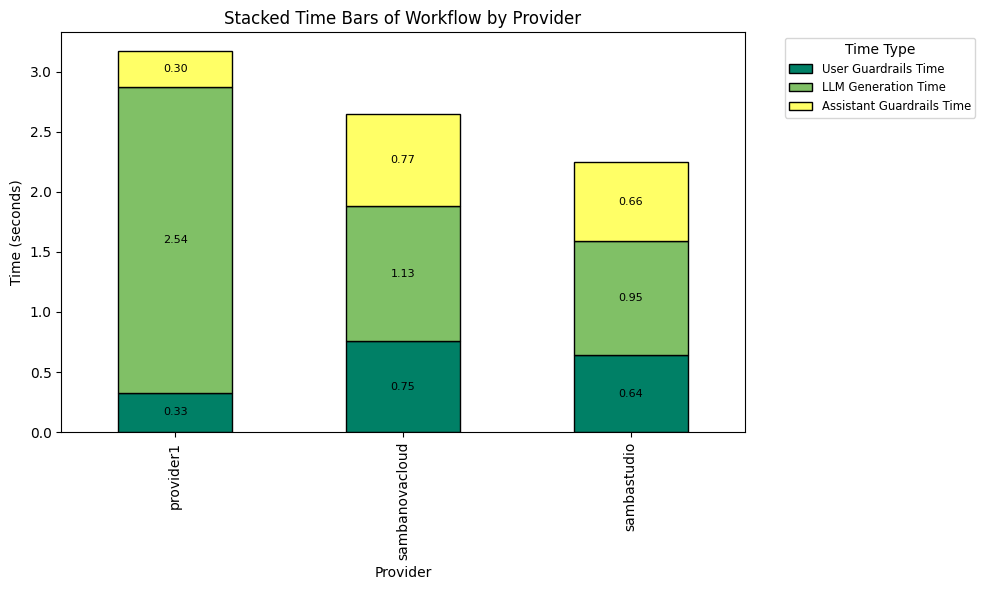

In [72]:
plot_comparison_stacked_barplots(df_metrics_short_prompts)

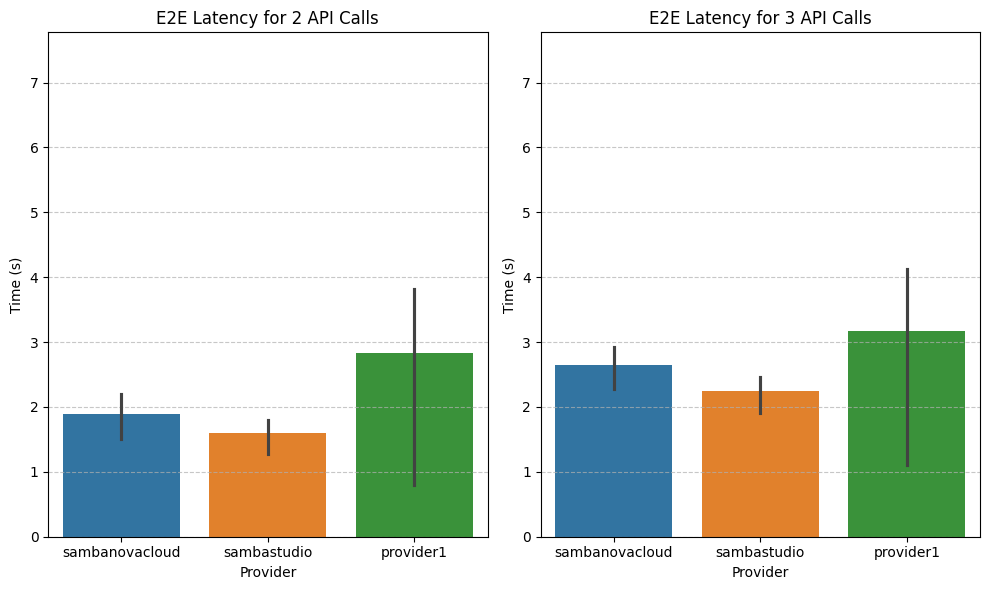

In [73]:
plot_comparison_barcharts(df_metrics_short_prompts)

# Benchamark with long prompts >1K

In [63]:
long_prompts=[
    """can you summarize the following article in 5000 characters, then create a bullet point list of the 100 top interesting facts:
    The Very Large Telescope (VLT) is an astronomical facility operated since 1998 by the European Southern Observatory, located on Cerro Paranal in the Atacama Desert of northern Chile. It consists of four individual telescopes, each equipped with a primary mirror that measures 8.2 metres (27 ft) in diameter. These optical telescopes, named Antu, Kueyen, Melipal, and Yepun (all words for astronomical objects in the Mapuche language), are generally used separately but can be combined to achieve a very high angular resolution.[1] The VLT array is also complemented by four movable Auxiliary Telescopes (ATs) with 1.8-metre (5.9 ft) apertures.
    The VLT is capable of observing both visible and infrared wavelengths. Each individual telescope can detect objects that are roughly four billion times fainter than what can be seen with the naked eye. When all the telescopes are combined, the facility can achieve an angular resolution of approximately 0.002 arcsecond. In single telescope mode, the angular resolution is about 0.05 arcseconds.[2]
    The VLT is one of the most productive facilities for astronomy, second only to the Hubble Space Telescope in terms of the number of scientific papers produced from facilities operating at visible wavelengths.[3] Some of the pioneering observations made using the VLT include the first direct image of an exoplanet, the tracking of stars orbiting around the supermassive black hole at the centre of the Milky Way, and observations of the afterglow of the furthest known gamma-ray burst.[4]
    General information
    VLT's four Unit Telescopes
    The VLT consists of an arrangement of four large, 8.2-metre (27 ft) diameter telescopes (called Unit Telescopes or UTs) with optical elements that can combine them into an astronomical interferometer (VLTI), which is used to resolve small objects. The interferometer also includes a set of four 1.8-metre (5.9 ft) diameter movable telescopes dedicated to interferometric observations. The first of the UTs started operating in May 1998 and was offered to the astronomical community on 1 April 1999. The other telescopes became operational in 1999 and 2000, enabling multi-telescope VLT capability. Four 1.8-metre Auxiliary Telescopes (ATs) have been added to the VLTI to make it available when the UTs are being used for other projects. These ATs were installed and became operational between 2004 and 2007.[1]
    The VLT's 8.2-meter telescopes were originally designed to operate in three modes:[5]
    as a set of four independent telescopes (this is the primary mode of operation).
    as a single large coherent interferometric instrument (the VLT Interferometer or VLTI), for extra resolution. This mode is used for observations of relatively bright sources with small angular extent.
    as a single large incoherent instrument, for extra light-gathering capacity. The instrumentation required to obtain a combined incoherent focus was not originally built. In 2009, new instrumentation proposals were put forward to potentially make that observing mode available.[6] Multiple telescopes are sometimes independently pointed at the same object, either to increase the total light-gathering power or to provide simultaneous observations with complementary instruments.
    Unit telescopes
    Laser used for adaptive optics. It excites sodium atoms in the atmosphere and creates a laser guide star.
    Upgrading Yepun (UT4) with the "Adaptive Optics Facility" in 2012[8]
    Unit telescope undergoing inspection[7]
    The UTs are equipped with a large set of instruments permitting observations to be performed from the near-ultraviolet to the mid-infrared (i.e. a large fraction of the light wavelengths accessible from the surface of the Earth), with the full range of techniques including high-resolution spectroscopy, multi-object spectroscopy, imaging, and high-resolution imaging. In particular, the VLT has several adaptive optics systems, which correct for the effects of atmospheric turbulence, providing images almost as sharp as if the telescope were in space. In the near-infrared, the adaptive optics images of the VLT are up to three times sharper than those of the Hubble Space Telescope, and the spectroscopic resolution is many times better than Hubble. The VLTs are noted for their high level of observing efficiency and automation.
    The primary mirrors of the UTs are 8.2 metres (26.9 ft) in diameter but, in practice, the pupil of the telescopes is defined by their secondary mirrors, effectively reducing the usable diameter to 8.0 metres (26.2 ft) at the Nasmyth focus and 8.1 metres (26.6 ft) at the Cassegrain focus
    """,
    
    """
    SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment.
    """
]
benchmark_results_long_prompts = run_benchmark(long_prompts, 15)

running iteration 0
	running prompt 0
	running prompt 1
running iteration 1
	running prompt 0
	running prompt 1
running iteration 2
	running prompt 0
	running prompt 1
running iteration 3
	running prompt 0
	running prompt 1
running iteration 4
	running prompt 0
	running prompt 1
running iteration 5
	running prompt 0
	running prompt 1
running iteration 6
	running prompt 0
	running prompt 1
running iteration 7
	running prompt 0
	running prompt 1
running iteration 8
	running prompt 0
	running prompt 1
running iteration 9
	running prompt 0
	running prompt 1
running iteration 10
	running prompt 0
	running prompt 1
running iteration 11
	running prompt 0
	running prompt 1
running iteration 12
	running prompt 0
	running prompt 1
running iteration 13
	running prompt 0
	running prompt 1
running iteration 14
	running prompt 0
	running prompt 1


In [64]:
df_metrics_long_prompts = get_metrics_as_table(benchmark_results_long_prompts)
df_stats_long_prompts = get_stats(df_metrics_long_prompts)
df_stats_long_prompts

user_guardrails_time                                \
                               mean       std       min       max   
Provider                                                            
provider1                  0.305821  0.072487  0.210574  0.616519   
sambanovacloud             0.812903  0.077341  0.713671  0.988686   
sambastudio                0.663617  0.030838  0.626218  0.745336   

               llm_generation_time                                \
                              mean       std       min       max   
Provider                                                           
provider1                 3.375570  2.534508  0.718217  7.423581   
sambanovacloud            1.287172  0.459661  0.766584  1.868346   
sambastudio               1.164506  0.477047  0.667619  1.666866   

               assistant_guardrails_time                                \
                                    mean       std       min       max   
Provider                                                                 
provider1                       0.463184  0.199618  0.202575  0.774876   
sambanovacloud                  0.769935  0.040146  0.713285  0.885549   
sambastudio                     0.652583  0.034409  0.616779  0.746178   

               e2e_2_calls_time                                \
                           mean       std       min       max   
Provider                                                        
provider1              3.681392  2.541044  1.022479  7.997341   
sambanovacloud         2.100075  0.485490  1.514951  2.774487   
sambastudio            1.828123  0.477673  1.301018  2.399510   

               e2e_3_calls_time                                
                           mean       std       min       max  
Provider                                                       
provider1              4.144576  2.714326  1.243489  8.719428  
sambanovacloud         2.870011  0.474086  2.312371  3.553892  
sambastudio            2.480706  0.480497  1.955870  3.047215

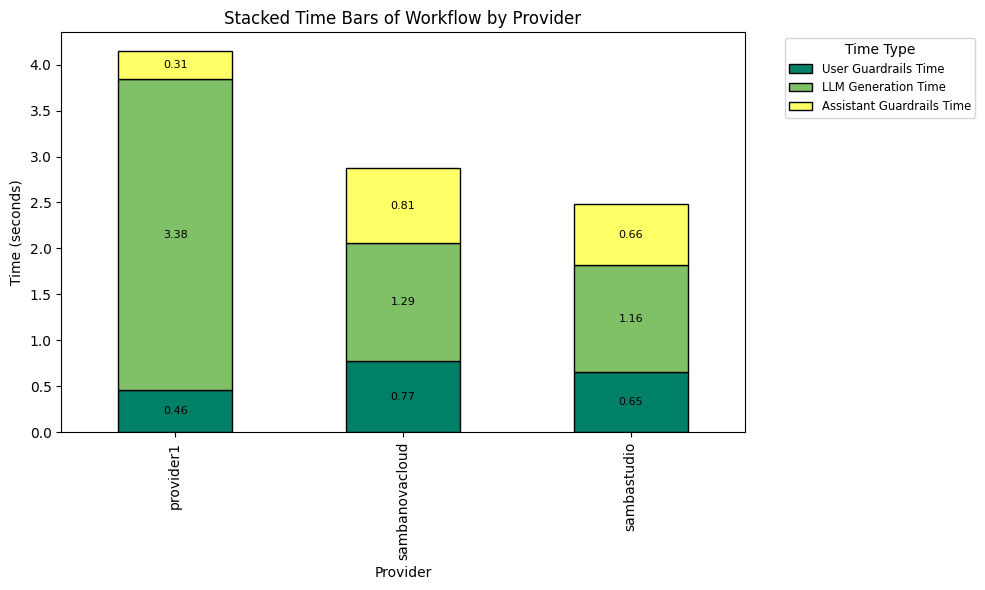

In [65]:
plot_comparison_stacked_barplots(df_metrics_long_prompts)

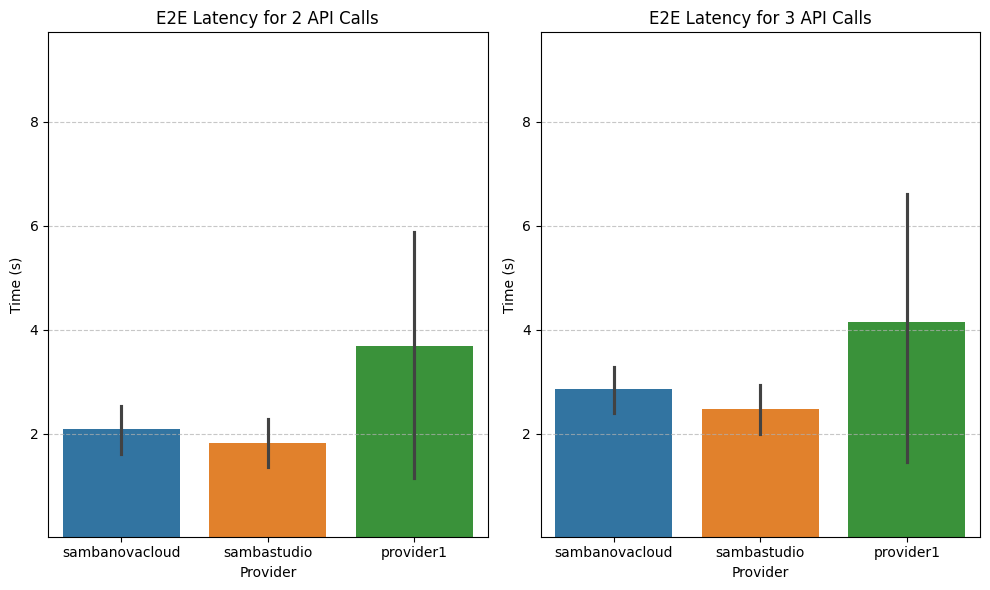

In [66]:
plot_comparison_barcharts(df_metrics_long_prompts)